In [ ]:
lrs = [i*0.000005 for i in range(1,11)]
epochs = [i*50 for i in range(1,7)]
batchs = [i*500 for i in range(1,11)]

dt_params = {
    'n_estimators' : [i*10 for i in range(5,15)], # 기본 100
    'max_depth' : [i for i in range(3,9)], # 기본 6
    'min_samples_split' : [i for i in range(1,5)], # 기본 2
    'min_samples_leaf' : [i for i in range(0,5)] # 기본 1
}

gb_params = {
    'learning_rate' : [i*0.05 for i in range(1,20)], # 기본 0.1
    'n_estimators' : [i*10 for i in range(5,15)], # 기본 100
    'min_samples_split' : [i for i in range(1,5)], # 기본 2
    'min_samples_leaf' : [i for i in range(0,5)], # 기본 1
    'max_depth' : [i for i in range(3,9)] # 기본 6
}

ab_params = {
    'n_estimators' : [i*10 for i in range(2,8)], # 기본 50
    'learning_rate' : [i*0.1 for i in range(1,10)] # 기본 1.0
}

In [2]:
import pandas as pd
from tensorflow.keras import utils

csv = pd.read_csv('ATP.csv')

X = csv.values[:,:15]
y = utils.to_categorical(csv.values[:,15], 2)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=1004)

CNN_X_train = X_train.reshape(X_train.shape[0], 15, 1, 1)
CNN_X_test = X_test.reshape(X_test.shape[0], 15, 1, 1)

In [27]:
from tensorflow.keras import layers, models, optimizers

def model_DNN(lr, epoch, batch):
    model = models.Sequential()
    model.add(layers.Dense(64, input_shape=(15,), activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(2,  activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr), metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epoch, verbose=0, batch_size=batch)
    score = model.evaluate(X_test, y_test, verbose=0)
    result.append(["DNN", 'Adam', lr, epoch, batch, round(history.history['accuracy'][-1],5) , round(score[1],5)])

def model_CNN(lr, epoch, batch):    
    model = models.Sequential()
    model.add(layers.Conv2D(64, kernel_size=(5,1), input_shape=(15,1,1), activation='relu'))
    model.add(layers.Conv2D(64, (5,1), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3,1)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy',  optimizer=optimizers.RMSprop(lr), metrics=['accuracy'])
    history = model.fit(CNN_X_train, y_train, epochs=epoch, verbose=0, batch_size=batch)
    score = model.evaluate(CNN_X_test, y_test, verbose=0)
    result.append(["CNN", 'RMSprop', lr, epoch, batch, round(history.history['accuracy'][-1],5) , round(score[1],5)])

In [23]:
result = []

for a in lrs:
    for b in epochs:
        for c in batchs:                
            model_CNN(a,b,c)
            model_DNN(a,b,c)

In [24]:
output = pd.DataFrame(result, columns=['Model','Optimizer','lr','epoch','batch','train_acc','test_acc'])
output.to_csv('CNN_DNN_result.csv', index=False)

[['CNN', 'RMSprop', 0.0001, 100, 100, 0.91243, 0.901],
 ['DNN', 'Adam', 0.0001, 100, 100, 0.82916, 0.80727]]

In [25]:
noh_y = csv.values[:,15]
nX_train, nX_test, ny_train, ny_test = train_test_split(X, noh_y, stratify=y, test_size=0.3, random_state=1004)

In [26]:
# 정렬 후 그래프 출력
import matplotlib.pyplot as plt

def sorting_plt(values):
    keys = csv.columns[:-1]
    lst = {}
    for i,j in zip(keys,values):
        lst[j] = i
    
    lst = sorted(lst.items(), reverse=0)
    
    plt.barh([i[1] for i in lst], [i[0] for i in lst])
    plt.show()

In [28]:
from sklearn.model_selection import GridSearchCV

def Grid_cv(model, params, X, y):
    grid_cv = GridSearchCV(model, param_grid=params, cv=3, n_jobs= -1)
    grid_cv.fit(X,y)
    return grid_cv

In [30]:
from sklearn.ensemble import RandomForestClassifier

# 그리디 알고리즘으로 최적의 매개변수 찾기
dt = RandomForestClassifier(random_state=0, n_jobs= -1)
dt_result = Grid_cv(dt, dt_params, X_train, y_train)

# 찾은 매개변수와 스코어 출력
print(dt_result.best_params_)
print(dt_result.best_score_)
print(dt_result.score(X_test, y_test))

from sklearn.ensemble import GradientBoostingClassifier

# 그리디 알고리즘으로 최적의 매개변수 찾기
gb = GradientBoostingClassifier(random_state=0)
gb_result = Grid_cv(gb, gb_params, nX_train, ny_train)

# 찾은 매개변수와 스코어 출력
print(gb_result.best_params_)
print(gb_result.best_score_)
print(gb_result.score(nX_test, ny_test))

from sklearn.ensemble import AdaBoostClassifier

# 그리디 알고리즘으로 최적의 매개변수 찾기
ab = AdaBoostClassifier(random_state=0)
ab_result = Grid_cv(ab, ab_params, nX_train, ny_train)

# 찾은 매개변수와 스코어 출력
print(ab_result.best_params_)
print(ab_result.best_score_)
print(ab_result.score(nX_test, ny_test))

{'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10}
0.9173504904279812
0.9076996652319465
{'learning_rate': 0.01, 'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10}
0.9126336771060019
0.8947871831659493
{'learning_rate': 1.0, 'n_estimators': 10}
0.9128379222253762
0.8914395026303205


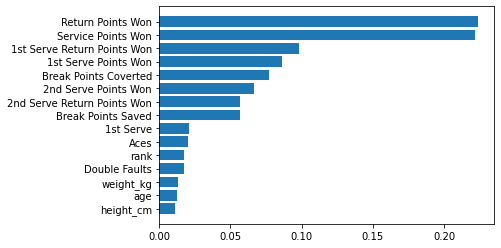

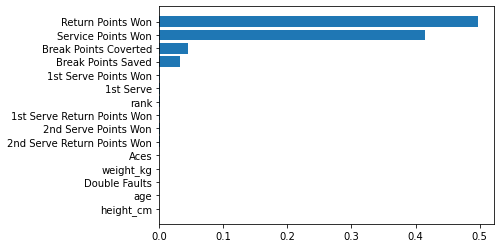

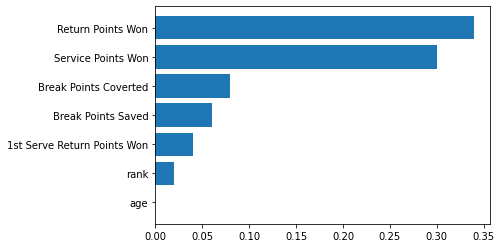

In [31]:
# 최적의 매개변수를 바탕으로 모델 학습
best_dt = RandomForestClassifier(random_state=0, n_jobs= -1)
best_dt.fit(X,y)

# 학습 후 그래프 출력
sorting_plt(best_dt.feature_importances_)

# 최적의 매개변수를 바탕으로 모델 학습
best_gb = GradientBoostingClassifier(random_state=0)
best_gb.fit(X, noh_y)

# 학습 후 그래프 출력
sorting_plt(best_gb.feature_importances_)

# 최적의 매개변수를 바탕으로 모델 학습
best_ab = AdaBoostClassifier(random_state=0)
best_ab.fit(X, noh_y)

# 학습 후 그래프 출력
sorting_plt(best_ab.feature_importances_)

In [ ]:
def valuesort(values):
    keys = csv.columns[:-1]
    lst = {}
    for i,j in zip(keys,values):
        lst[j] = i

    lst = sorted(lst.items(), reverse=1)

    return lst

df_rf = pd.DataFrame(dt_result.cv_results_)
df_rf['model'] = "RandomForest"

df_gb = pd.DataFrame(gb_result.cv_results_)
df_gb['model'] = "GradientBoosting"

df_ab = pd.DataFrame(ab_result.cv_results_)
df_ab['model'] = "AdaBoost"

weight_rf = pd.DataFrame(valuesort(best_dt.feature_importances_), columns=['weight','title'])
weight_gb = pd.DataFrame(valuesort(best_gb.feature_importances_), columns=['weight','title'])
weight_ab = pd.DataFrame(valuesort(best_ab.feature_importances_), columns=['weight','title'])

weight_rf[['title','weight']].to_csv('RandomForest_Weight.csv', index=0, encoding='utf-8-sig')
weight_gb[['title','weight']].to_csv('GradientBoosting_Weight.csv', index=0, encoding='utf-8-sig')
weight_ab[['title','weight']].to_csv('AdaBoost_Weight.csv', index=0, encoding='utf-8-sig')

df_1 = pd.concat([df_rf, df_gb])
df_2 = pd.concat([df_1, df_ab])

df_3 = pd.DataFrame()
df_3['model'] = df_2['model']
df_3['score'] = df_2['mean_test_score']
df_3['params'] = df_2['params']

df_3.to_csv('Model_Score.csv', index=0)

In [32]:
import warnings
warnings.filterwarnings(action='ignore')

In [49]:
import pandas as pd
from tensorflow.keras import utils
import numpy as np

bad_data = pd.read_csv('Badmintain.csv')

Bad_X = bad_data.values[:,:21]
Bad_noh_y = bad_data.values[:,21]

Bad_y = []
for i in Bad_noh_y:
    if i < 137*0.5:
        Bad_y.append(0)
    else:
        Bad_y.append(1)

Bad_noh_y = np.array(Bad_y)
Bad_y = utils.to_categorical(Bad_y, 2)

In [50]:
from sklearn.model_selection import train_test_split

Bad_X_train, Bad_X_test, Bad_y_train, Bad_y_test = train_test_split(Bad_X, Bad_y, stratify=Bad_y, test_size=0.2, random_state=1004)
Bad_nX_train, Bad_nX_test, Bad_ny_train, Bad_ny_test = train_test_split(Bad_X, Bad_noh_y, stratify=Bad_noh_y, test_size=0.2, random_state=1004)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Bad_dt = RandomForestClassifier(random_state=0, n_jobs= -1)
Bad_dt_result = Grid_cv(Bad_dt, dt_params, nX_train, ny_train)

print(Bad_dt_result.best_params_)
print(Bad_dt_result.best_score_)
print(Bad_dt_result.score(nX_test, ny_test))

from sklearn.ensemble import GradientBoostingClassifier

Bad_gb = GradientBoostingClassifier(random_state=0)
Bad_gb_result = Grid_cv(Bad_gb, gb_params, nX_train, ny_train)

print(Bad_gb_result.best_params_)
print(Bad_gb_result.best_score_)
print(Bad_gb_result.score(nX_test, ny_test))

from sklearn.ensemble import AdaBoostClassifier

Bad_ab = AdaBoostClassifier(random_state=0)
Bad_ab_result = Grid_cv(Bad_ab, ab_params, nX_train, ny_train)

print(Bad_ab_result.best_params_)
print(Bad_ab_result.best_score_)
print(Bad_ab_result.score(nX_test, ny_test))

In [ ]:
# 최적의 매개변수를 바탕으로 모델 학습
Bad_best_dt = RandomForestClassifier(random_state=0, n_jobs= -1)
Bad_best_dt.fit(Bad_X,Bad_y)

# 학습 후 그래프 출력
sorting_plt(Bad_best_dt.feature_importances_)

# 최적의 매개변수를 바탕으로 모델 학습
Bad_best_gb = GradientBoostingClassifier(random_state=0)
Bad_best_gb.fit(Bad_X, Bad_noh_y)

# 학습 후 그래프 출력
sorting_plt(Bad_best_gb.feature_importances_)

# 최적의 매개변수를 바탕으로 모델 학습
Bad_best_ab = AdaBoostClassifier(random_state=0)
Bad_best_ab.fit(Bad_X, Bad_noh_y)

# 학습 후 그래프 출력
sorting_plt(Bad_best_ab.feature_importances_)

In [ ]:
Bad_df_dt = pd.DataFrame(Bad_dt_result.cv_results_)
Bad_df_dt['model'] = "RandomForest"

Bad_df_gb = pd.DataFrame(Bad_gb_result.cv_results_)
Bad_df_gb['model'] = "GradientBoosting"

Bad_df_ab = pd.DataFrame(Bad_ab_result.cv_results_)
Bad_df_ab['model'] = "AdaBoost"

Bad_weight_dt = pd.DataFrame(valuesort(Bad_best_dt.feature_importances_), columns=['weight','title'])
Bad_weight_gb = pd.DataFrame(valuesort(Bad_best_gb.feature_importances_), columns=['weight','title'])
Bad_weight_ab = pd.DataFrame(valuesort(Bad_best_ab.feature_importances_), columns=['weight','title'])

Bad_weight_dt[['title','weight']].to_csv('Bad_RandomForest_Weight.csv', index=0, encoding='utf-8-sig')
Bad_weight_gb[['title','weight']].to_csv('Bad_GradientBoosting_Weight.csv', index=0, encoding='utf-8-sig')
Bad_weight_ab[['title','weight']].to_csv('Bad_AdaBoost_Weight.csv', index=0, encoding='utf-8-sig')

Bad_df_1 = pd.concat([Bad_df_dt, Bad_df_gb])
Bad_df_2 = pd.concat([Bad_df_1, Bad_df_ab])

Bad_df_3 = pd.DataFrame()
Bad_df_3['model'] = Bad_df_2['model']
Bad_df_3['score'] = Bad_df_2['mean_test_score']
Bad_df_3['params'] = Bad_df_2['params']

Bad_df_3.to_csv('Bad_Model_Score.csv', index=0)